# install necessary Libs

In [ ]:
!pip install pandas
!pip install lightfm

# import liberies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
###############################################
# Load  ModCloth Dataset
###############################################

file_path = "modcloth_final_data.json"
df_modcloth = pd.read_json(file_path, lines=True)

# Print stats dataset

In [4]:
###############################################
#  Analyze ModCloth Dataset
###############################################

def print_stats(df, name):
    print(f"\n--- {name} ---")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isna().sum())
    print("Duplicates:", df.duplicated().sum())
    print(df.describe(include="all"))
    stats = {}
    stats["Dataset"] = name
    stats["Number of users"] = df["user_id"].nunique()
    stats["Number of items"] = df["item_id"].nunique()
    stats["Total interactions"] = len(df)
    stats["Average interactions per user"] = df.groupby("user_id").size().mean()
    user_item_matrix = df.pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)
    sparsity = 1 - np.count_nonzero(user_item_matrix.values) / float(user_item_matrix.size)
    stats["Sparsity of user-item matrix"] = sparsity

    stats["Number of unique items per user"] = df.groupby('user_id')['item_id'].nunique().mean()
    stats["Number of unique users per item"] = df.groupby('item_id')['user_id'].nunique().mean()

    if "rating" in df.columns:
        stats["Median rating"] = df["rating"].median()
        stats["Rating std"] = df["rating"].std()
    print(stats)
print_stats(df_modcloth, "ModCloth (Before Cleaning)")


--- ModCloth (Before Cleaning) ---
Shape: (82790, 18)
Missing values:
 item_id               0
waist             79908
size                  0
quality              68
cup size           6255
hips              26726
bra size           6018
category              0
bust              70936
height             1107
user_name             0
length               35
fit                   0
user_id               0
shoe size         54875
shoe width        64183
review_summary     6725
review_text        6725
dtype: int64
Duplicates: 377
              item_id        waist          size       quality cup size  \
count    82790.000000  2882.000000  82790.000000  82722.000000    76535   
unique            NaN          NaN           NaN           NaN       12   
top               NaN          NaN           NaN           NaN        c   
freq              NaN          NaN           NaN           NaN    18370   
mean    469325.229170    31.319223     12.661602      3.949058      NaN   
std     213999.80

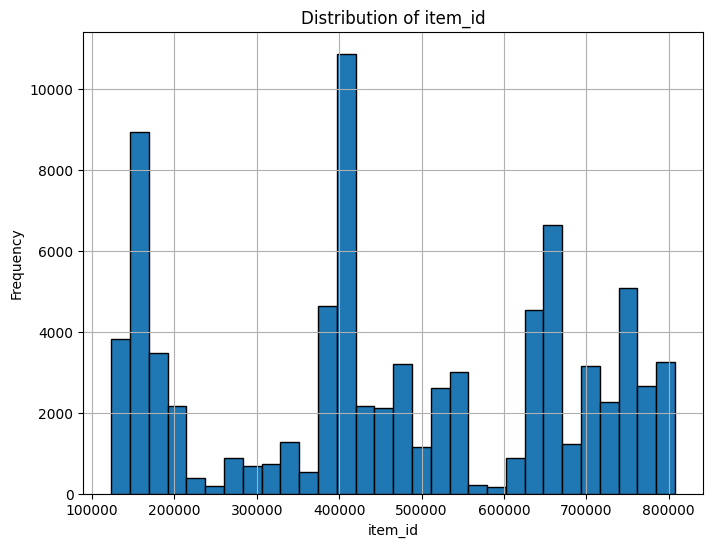


--- Distribution of item_id ---
count     82790.000000
mean     469325.229170
std      213999.803314
min      123373.000000
25%      314980.000000
50%      454030.000000
75%      658440.000000
max      807722.000000
Name: item_id, dtype: float64


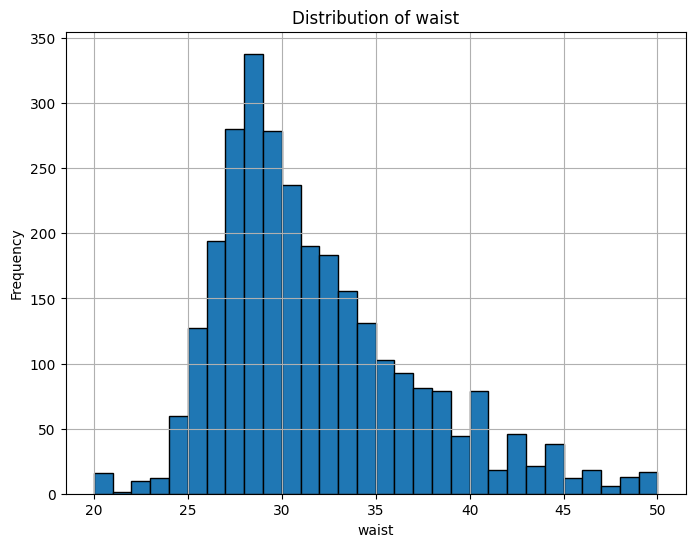


--- Distribution of waist ---
count    2882.000000
mean       31.319223
std         5.302849
min        20.000000
25%        28.000000
50%        30.000000
75%        34.000000
max        50.000000
Name: waist, dtype: float64


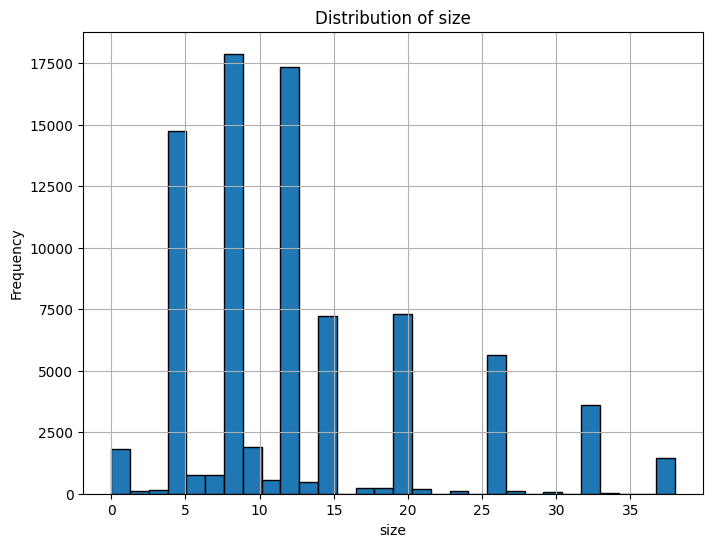


--- Distribution of size ---
count    82790.000000
mean        12.661602
std          8.271952
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         38.000000
Name: size, dtype: float64


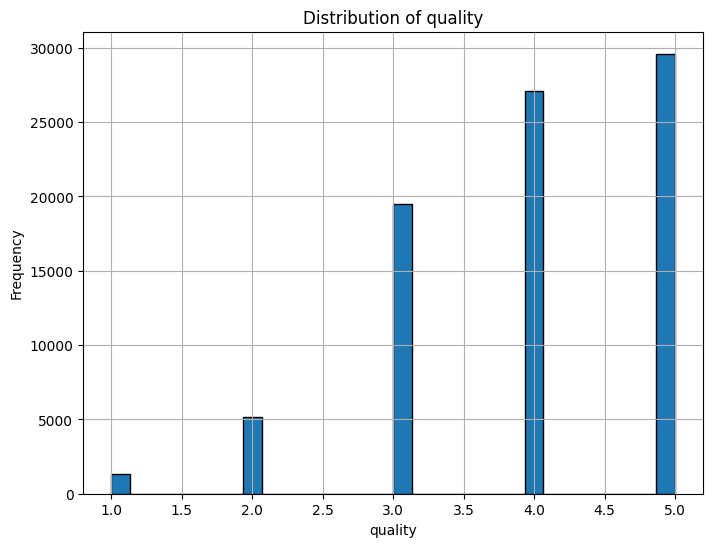


--- Distribution of quality ---
count    82722.000000
mean         3.949058
std          0.992783
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: quality, dtype: float64


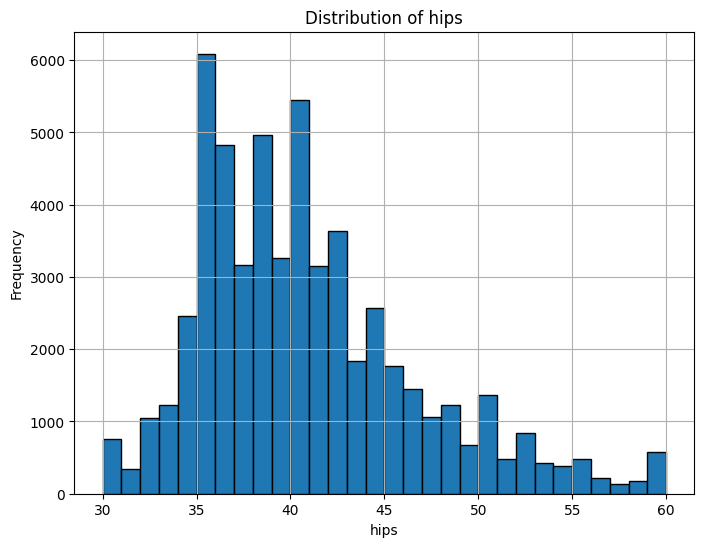


--- Distribution of hips ---
count    56064.000000
mean        40.358501
std          5.827166
min         30.000000
25%         36.000000
50%         39.000000
75%         43.000000
max         60.000000
Name: hips, dtype: float64


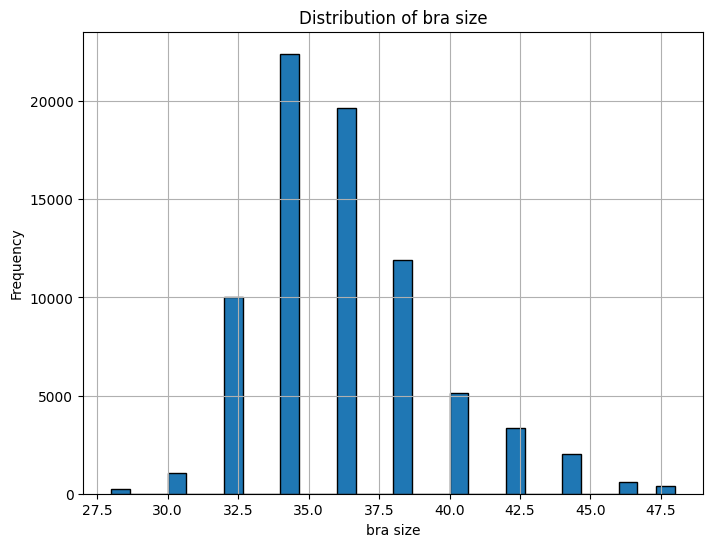


--- Distribution of bra size ---
count    76772.000000
mean        35.972125
std          3.224907
min         28.000000
25%         34.000000
50%         36.000000
75%         38.000000
max         48.000000
Name: bra size, dtype: float64


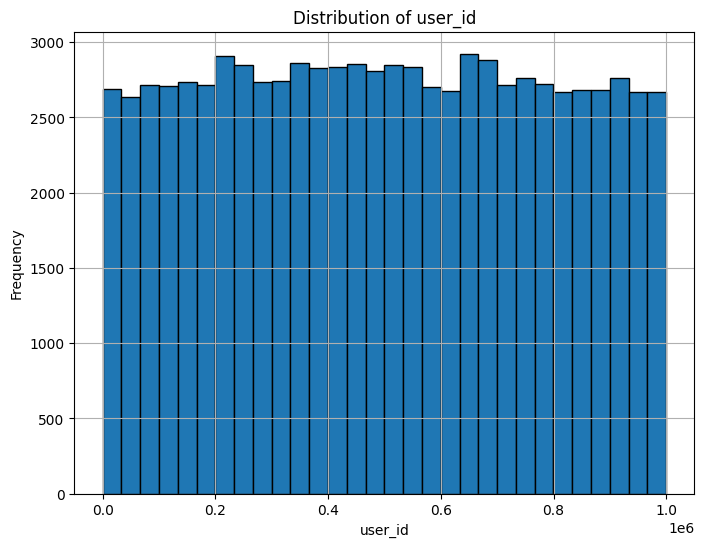


--- Distribution of user_id ---
count     82790.000000
mean     498849.564718
std      286356.969459
min           6.000000
25%      252897.750000
50%      497913.500000
75%      744745.250000
max      999972.000000
Name: user_id, dtype: float64


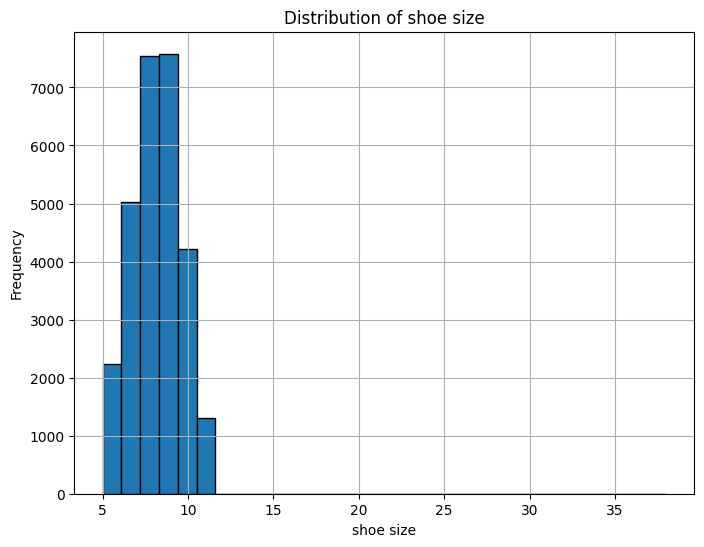


--- Distribution of shoe size ---
count    27915.000000
mean         8.145818
std          1.336109
min          5.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         38.000000
Name: shoe size, dtype: float64


In [5]:
def plot_feature_distributions(df):
    """Plots the distribution of each numerical feature in the DataFrame."""
    numerical_features = df.select_dtypes(include=np.number).columns

    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        plt.hist(df[feature].dropna(), bins=30, edgecolor='k')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

        print(f"\n--- Distribution of {feature} ---")
        print(df[feature].describe())

plot_feature_distributions(df_modcloth)


--- Distribution of item_id ---
count     82790.000000
mean     469325.229170
std      213999.803314
min      123373.000000
25%      314980.000000
50%      454030.000000
75%      658440.000000
max      807722.000000
Name: item_id, dtype: float64

--- Distribution of waist ---
count    2882.000000
mean       31.319223
std         5.302849
min        20.000000
25%        28.000000
50%        30.000000
75%        34.000000
max        50.000000
Name: waist, dtype: float64

--- Distribution of size ---
count    82790.000000
mean        12.661602
std          8.271952
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         38.000000
Name: size, dtype: float64

--- Distribution of quality ---
count    82722.000000
mean         3.949058
std          0.992783
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: quality, dtype: float64


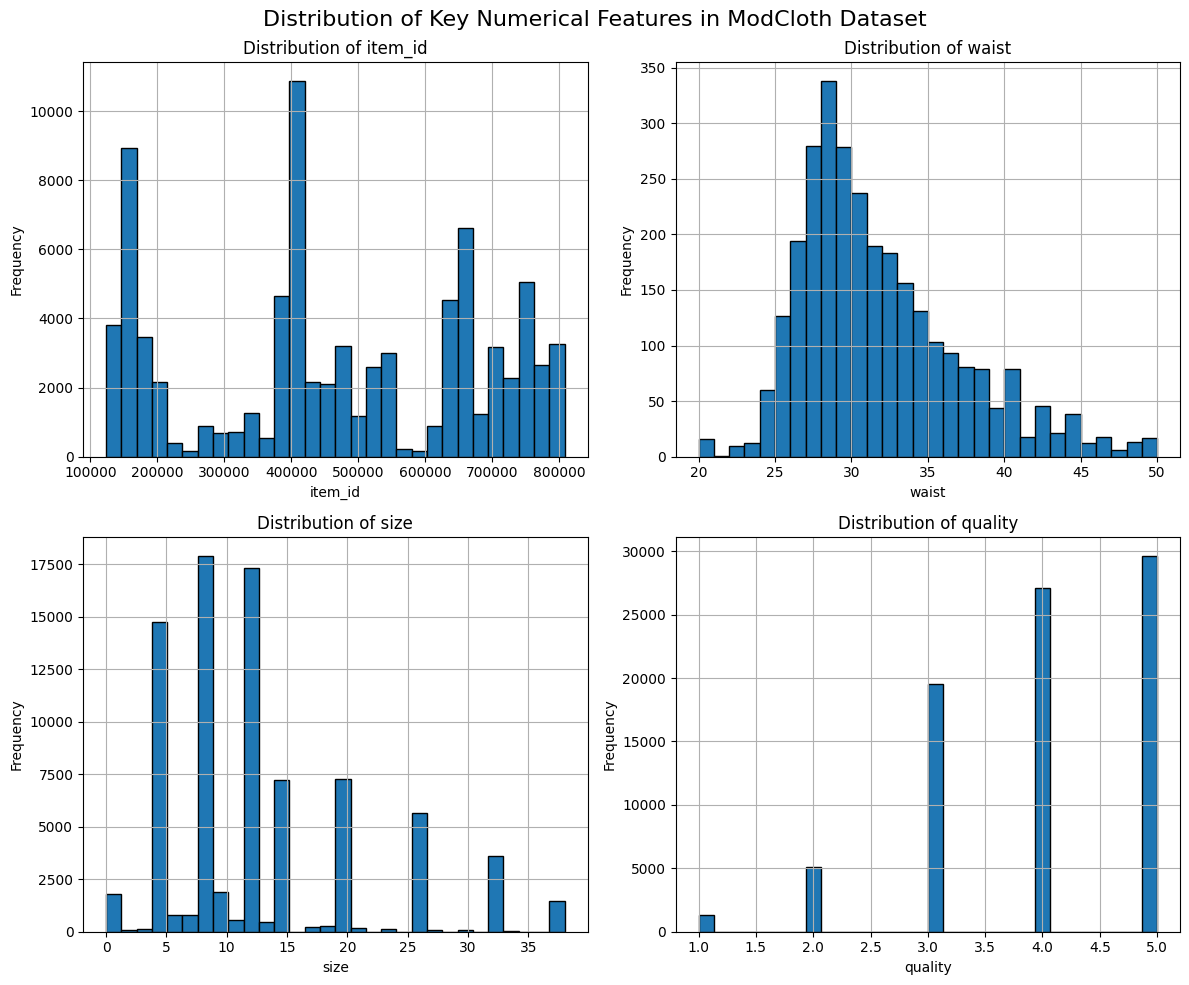

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_distributions_matrix(df):
    """Plots the distribution of the first four numerical features in a 2x2 matrix."""
    numerical_features = df.select_dtypes(include=np.number).columns
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes = axes.flatten()

    for i, feature in enumerate(numerical_features[:4]):
        axes[i].hist(df[feature].dropna(), bins=30, edgecolor='k')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)

        print(f"\n--- Distribution of {feature} ---")
        print(df[feature].describe())

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle('Distribution of Key Numerical Features in ModCloth Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_feature_distributions_matrix(df_modcloth)

#Preprocessing

In [7]:
###############################################
#  Preprocessing
###############################################

df_modcloth_clean = df_modcloth.dropna(subset=["user_id","item_id"]).drop_duplicates()

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
category_bow = vectorizer.fit_transform(df_modcloth_clean['category'])


In [9]:
df_modcloth_clean.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [10]:
###############################################
# 3. Implicit Feedback
###############################################

fit_mapping = {'fit': 0, 'large': 2, 'small': 1}
df_modcloth_clean.loc[:, 'fit'] = df_modcloth_clean['fit'].map(fit_mapping)


user_reviews = df_modcloth_clean.groupby('user_id')['review_text'].count().to_dict()
df_modcloth_clean.loc[:, 'num_user_reviews'] = df_modcloth_clean['user_id'].map(user_reviews).fillna(0).astype(int)
max_reviews = df_modcloth_clean['num_user_reviews'].max()
df_modcloth_clean.loc[:, 'num_user_reviews_normalized'] = df_modcloth_clean['num_user_reviews'] / max_reviews

max_quality = df_modcloth_clean['quality'].max()
df_modcloth_clean.loc[:, 'quality_normalized'] = df_modcloth_clean['quality'] / max_quality


df_modcloth_clean.loc[:, 'interaction_strength'] = (
    df_modcloth_clean['fit'] * 0.33 +
    df_modcloth_clean['num_user_reviews'] * 0.33 +
    df_modcloth_clean['quality'] * 0.34
)

In [11]:
df_modcloth_clean['fit'] = df_modcloth_clean['fit'].fillna(df_modcloth_clean['fit'].median())
df_modcloth_clean['num_user_reviews'] = df_modcloth_clean['num_user_reviews'].fillna(df_modcloth_clean['num_user_reviews'].median())
df_modcloth_clean['quality'] = df_modcloth_clean['quality'].fillna(df_modcloth_clean['quality'].median())

<ipython-input-11-939be0d95d69>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_modcloth_clean['fit'] = df_modcloth_clean['fit'].fillna(df_modcloth_clean['fit'].median())



--- Distribution of size ---
count    82413.000000
mean        12.659714
std          8.270768
min          0.000000
25%          8.000000
50%         12.000000
75%         15.000000
max         38.000000
Name: size, dtype: float64

--- Distribution of quality ---
count    82413.000000
mean         3.949134
std          0.992429
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: quality, dtype: float64

--- Distribution of fit ---
count    82413.000000
mean         0.471928
std          0.751403
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          2.000000
Name: fit, dtype: float64

--- Distribution of num_user_reviews ---
count    82413.000000
mean         2.921020
std          3.049227
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         25.000000
Name: num_user_reviews, dtype: float64


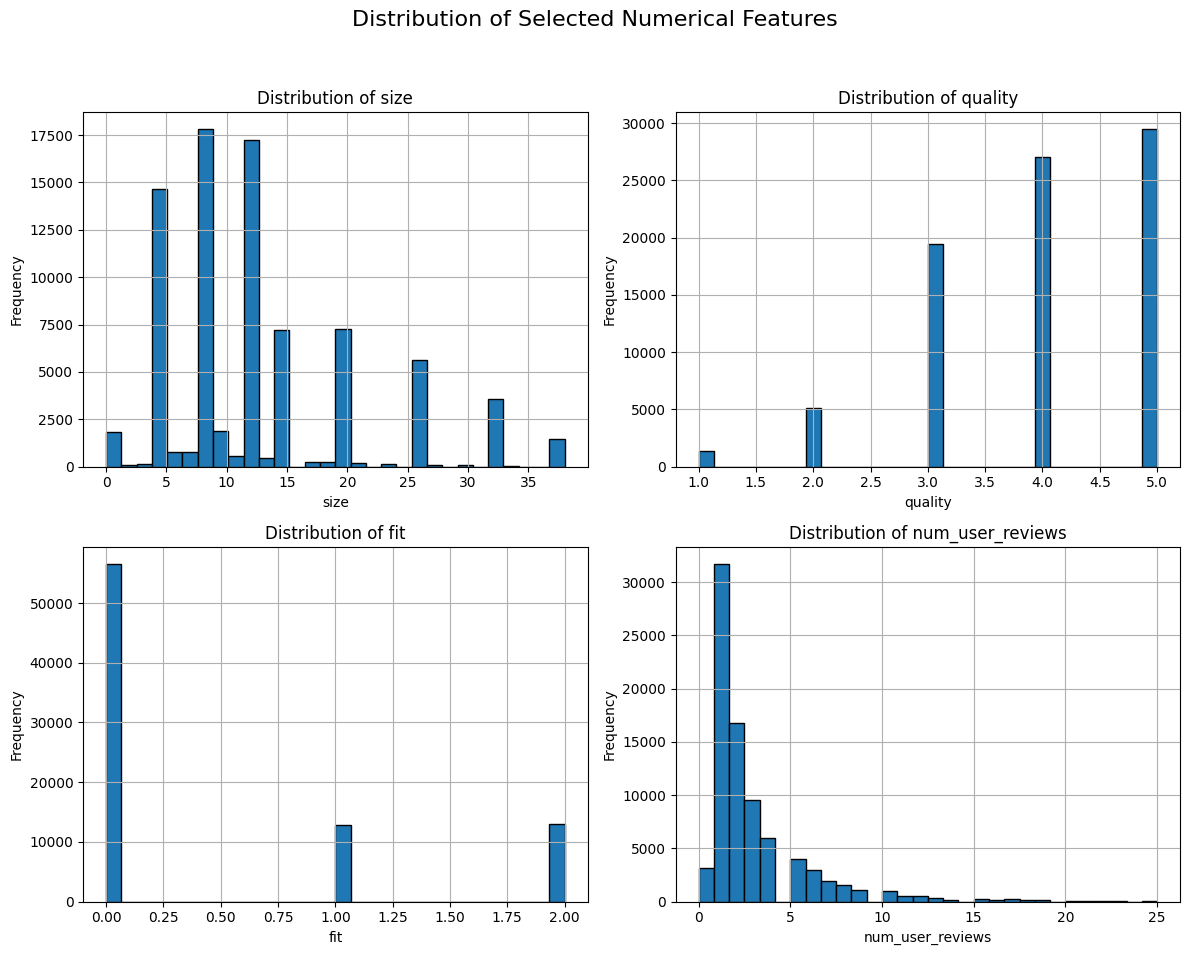

In [12]:
###############################################
#  Plot feature Distribution
###############################################

import numpy as np
import matplotlib.pyplot as plt

def plot_selected_feature_distributions_matrix_with_caption(df, features_to_plot):
    """
    Plots the distribution of selected numerical features in a 2x2 matrix with a caption.

    Args:
        df: The DataFrame containing the data.
        features_to_plot: A list of numerical feature names to plot.
                          Should contain at most 4 feature names for a 2x2 matrix.
    """
    if len(features_to_plot) > 4:
        print("Warning: More than 4 features provided. Plotting only the first 4.")
        features_to_plot = features_to_plot[:4]


    fig, axes = plt.subplots(2, 2, figsize=(12, 10))


    axes = axes.flatten()


    for i, feature in enumerate(features_to_plot):
        if feature in df.columns and np.issubdtype(df[feature].dtype, np.number):
            axes[i].hist(df[feature].dropna(), bins=30, edgecolor='k')  #
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            axes[i].grid(True)

            print(f"\n--- Distribution of {feature} ---")
            print(df[feature].describe())
        else:
            print(f"Warning: Feature '{feature}' not found or not numerical. Skipping.")
            fig.delaxes(axes[i])


    for j in range(len(features_to_plot), len(axes)):
        fig.delaxes(axes[j])



    fig.suptitle('Distribution of Selected Numerical Features', fontsize=16) # <- maybe remove in thesis

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


features_to_visualize = ['size', 'quality', 'fit', 'num_user_reviews']

plot_selected_feature_distributions_matrix_with_caption(df_modcloth_clean, features_to_visualize)

# Sparsity Calculation

In [13]:
def calculate_sparsity(df):
    """Calculates sparsity for each numerical feature in the DataFrame.

    Args: dataset as df
    Return : dictionary with item feature name and sparsity values
    """
    numerical_features = df.select_dtypes(include=np.number).columns
    sparsity_results = {}

    for feature in numerical_features:
        sparsity = df[feature].isnull().sum() / len(df)
        sparsity_results[feature] = sparsity

    return sparsity_results
sparsity_dict = calculate_sparsity(df_modcloth_clean)
for feature, sparsity in sparsity_dict.items():
    print(f"Sparsity of {feature}: {sparsity:.2f}")

Sparsity of item_id: 0.00
Sparsity of waist: 0.97
Sparsity of size: 0.00
Sparsity of quality: 0.00
Sparsity of hips: 0.32
Sparsity of bra size: 0.07
Sparsity of fit: 0.00
Sparsity of user_id: 0.00
Sparsity of shoe size: 0.66
Sparsity of num_user_reviews: 0.00
Sparsity of num_user_reviews_normalized: 0.00
Sparsity of quality_normalized: 0.00


# More than 2 interactions

In [14]:
def preprocess_data(df, sparsity_threshold=0.50, user_id_col='user_id'):
    """Preprocesses the data by removing numerical features with high sparsity
    Args:
    df : dataset
    sparsity_threshold: how sparse can a feature be to be accepted
    user_id columns

    Return:
    preprocessed dataset -> df_modcloth_clean
    """
    numerical_cols = df.select_dtypes(include=np.number).columns
    cols_to_check = [col for col in numerical_cols if col != user_id_col]

    for col in cols_to_check:
        sparsity = df[col].isnull().sum() / len(df)
        if sparsity > sparsity_threshold:
            print(f"Dropping sparse feature: {col} (Sparsity: {sparsity:.2f})")
            df = df.drop(col, axis=1)

    user_interaction_counts = df_modcloth_clean.groupby('user_id')['interaction_strength'].count()
    print(user_interaction_counts)
    users_with_more_than_two_interactions = user_interaction_counts[user_interaction_counts >= 2]
    print(f"Number of users with more than 2 interactions: {len(users_with_more_than_two_interactions)}")
    df = df_modcloth_clean[df_modcloth_clean["user_id"].isin(users_with_more_than_two_interactions.index)]

    return df

In [15]:
df_modcloth_clean = preprocess_data(df_modcloth_clean, sparsity_threshold=0.50)

Dropping sparse feature: waist (Sparsity: 0.97)
Dropping sparse feature: shoe size (Sparsity: 0.66)
user_id
6         1
46        1
55        1
66        4
104       2
         ..
999864    1
999887    2
999888    1
999923    3
999972    3
Name: interaction_strength, Length: 47958, dtype: int64
Number of users with more than 2 interactions: 15924


# Plot user activity

In [16]:

def print_stats(df, name):
    print(f"\n--- {name} ---")
    print("Shape:", df.shape)
    print("Missing values:\n", df.isna().sum())

    columns_to_check_duplicates = [col for col in df.columns if col != 'tokens']
    print("Duplicates:", df[columns_to_check_duplicates].duplicated().sum())
    print(df.describe(include="all"))
    stats = {}
    stats["Dataset"] = name
    stats["Number of users"] = df["user_id"].nunique()
    stats["Number of items"] = df["item_id"].nunique()
    stats["Total interactions"] = len(df)
    stats["Average interactions per user"] = df.groupby("user_id").size().mean()

    user_item_matrix = df.pivot_table(index='user_id', columns='item_id', aggfunc='size', fill_value=0)
    sparsity = 1 - np.count_nonzero(user_item_matrix.values) / float(user_item_matrix.size)
    stats["Sparsity of user-item matrix"] = sparsity

    stats["Number of unique items per user"] = df.groupby('user_id')['item_id'].nunique().mean()
    stats["Number of unique users per item"] = df.groupby('item_id')['user_id'].nunique().mean()

    if "rating" in df.columns:
        stats["Median rating"] = df["rating"].median()
        stats["Rating std"] = df["rating"].std()
    print(stats)

In [17]:
user_activity = df_modcloth_clean.groupby('user_id')['interaction_strength'].sum()

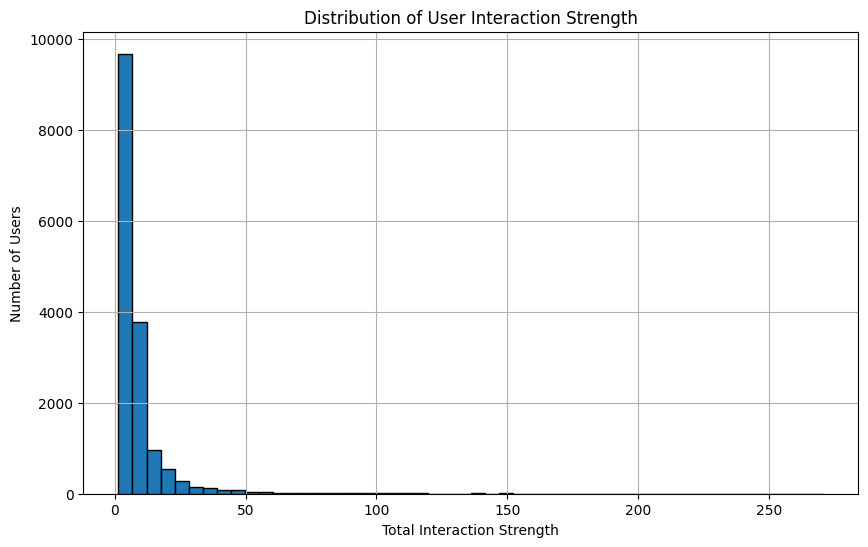


--- ModCloth (After Cleaning) ---
Shape: (50371, 22)
Missing values:
 item_id                            0
waist                          49212
size                               0
quality                            0
cup size                        2870
hips                           15102
bra size                        2720
category                           0
bust                           42593
height                           597
user_name                          0
length                             2
fit                                0
user_id                            0
shoe size                      30859
shoe width                     37146
review_summary                  3672
review_text                     3672
num_user_reviews                   0
num_user_reviews_normalized        0
quality_normalized                12
interaction_strength              12
dtype: int64
Duplicates: 0
              item_id        waist          size       quality cup size  \
count    5037

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(user_activity, bins=50, edgecolor='k')
plt.title('Distribution of User Interaction Strength')
plt.xlabel('Total Interaction Strength')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()

print_stats(df_modcloth_clean, "ModCloth (After Cleaning)")

# Divide df in different user engagement levels

Every row in your df_modcloth_clean DataFrame will have a value in the new user_activity column. Since each row is associated with a user_id, and the transform('sum') operation calculates the total interaction strength for each user_id present in the DataFrame and applies the mapping to every row corresponding to that user, every single record will be assigned either 'Low' or 'High' in the user_activity column.

In [19]:
median_interaction_strength = df_modcloth_clean.groupby('user_id')['interaction_strength'].sum().median()
print(median_interaction_strength)
df_modcloth_clean['user_activity'] = df_modcloth_clean.groupby('user_id')['interaction_strength'].transform('sum').map(
    lambda x: 'Low' if x < median_interaction_strength else 'High'
)

print(df_modcloth_clean['user_activity'].value_counts())
print(f"Number of users in df_modcloth_clean: {df_modcloth_clean['user_id'].nunique()}")

5.040000000000001
user_activity
High    34900
Low     15471
Name: count, dtype: int64
Number of users in df_modcloth_clean: 15924


In [20]:
user_activity_counts = df_modcloth_clean.groupby('user_activity')['user_id'].nunique()
print("Number of unique users in each activity group:")
print(user_activity_counts)

Number of unique users in each activity group:
user_activity
High    8218
Low     7706
Name: user_id, dtype: int64


In [21]:
user_interactions = df_modcloth.groupby('user_id').size()
print(user_interactions)

user_id
6         1
46        1
55        1
66        4
104       2
         ..
999864    1
999887    2
999888    1
999923    3
999972    3
Length: 47958, dtype: int64


user_activity
High    34900
Low     15471
Name: count, dtype: int64


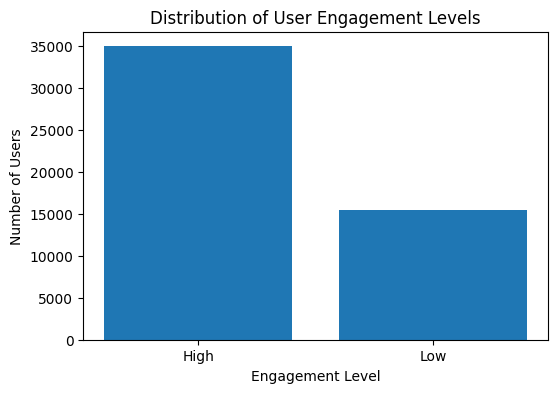

In [22]:

engagement_counts = df_modcloth_clean['user_activity'].value_counts()
print(engagement_counts)
plt.figure(figsize=(6, 4))
plt.bar(engagement_counts.index, engagement_counts.values)
plt.xlabel("Engagement Level")
plt.ylabel("Number of Users")
plt.title("Distribution of User Engagement Levels")
plt.show()

# Train test

In [23]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df_modcloth_clean, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


# User item matrix

In [24]:
###############################################
# 3. User Item Matrix
###############################################

# Rows = users.
#Columns = items.
#cell values represent user  interacted with an item.

train_user_item_matrix = train_df.pivot_table(
    index="user_id",
    columns="item_id",
    values="interaction_strength",
    aggfunc="sum",
    fill_value=0
)
val_user_item_matrix = val_df.pivot_table(
    index="user_id",
    columns="item_id",
    values="interaction_strength",
    aggfunc="sum",
    fill_value=0
)
test_user_item_matrix = test_df.pivot_table(
    index="user_id",
    columns="item_id",
    values="interaction_strength",
    aggfunc="sum",
    fill_value=0
)

<ipython-input-24-f947f7bf47dd>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_user_item_matrix = train_df.pivot_table(
<ipython-input-24-f947f7bf47dd>:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_user_item_matrix = val_df.pivot_table(
<ipython-input-24-f947f7bf47dd>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_

# nearest neighbors

#hyperparameter

In [25]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score

best_params = None
best_precision = 0

train_user_item_matrix = train_df.pivot_table(index="user_id", columns="item_id", values="interaction_strength", aggfunc="sum", fill_value=0)
val_user_item_matrix = val_df.pivot_table(index="user_id", columns="item_id", values="interaction_strength", aggfunc="sum", fill_value=0)

val_user_item_matrix = val_user_item_matrix.reindex(columns=train_user_item_matrix.columns, fill_value=0)

def evaluate_model(model, train_data, val_data, k=5):
    """Evaluates the model using precision@k on the validation set."""

    distances, indices = model.kneighbors(val_data, n_neighbors=k)

    precisions = []

    for i in range(len(val_data)):
        actual_items = val_data.iloc[i][val_data.iloc[i] > 0].index.tolist()
        predicted_items = [train_data.columns[j] for j in indices[i] if j < len(train_data.columns)]

        num_relevant_recommendations = len(set(actual_items) & set(predicted_items))

        precision = num_relevant_recommendations / k if k > 0 else 0
        precisions.append(precision)

    return np.mean(precisions)

param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'algorithm': ['auto', 'ball_tree',  'brute'],
    'metric': ['cosine', 'euclidean'] ,
    'k': [5, 10, 15, 20]
}

filtered_param_grid = []
for params in ParameterGrid(param_grid):
    if params['algorithm'] == 'ball_tree' and params['metric'] == 'cosine':
        continue
    else:
        filtered_param_grid.append(params)


for params in filtered_param_grid:
    model = NearestNeighbors(n_neighbors=params['n_neighbors'], algorithm=params['algorithm'], metric=params['metric'])
    model.fit(train_user_item_matrix)
    precision = evaluate_model(model, train_user_item_matrix, val_user_item_matrix, k=params['k'])
    if precision > best_precision:
        best_precision = precision
        best_params = params

print(f"Best hyperparameters: {best_params}")
print(f"Best precision@k: {best_precision}")

<ipython-input-25-ced983765a74>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_user_item_matrix = train_df.pivot_table(index="user_id", columns="item_id", values="interaction_strength", aggfunc="sum", fill_value=0)
<ipython-input-25-ced983765a74>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_user_item_matrix = val_df.pivot_table(index="user_id", columns="item_id", values="interaction_strength", aggfunc="sum", fill_value=0)


Best hyperparameters: {'algorithm': 'auto', 'k': 10, 'metric': 'euclidean', 'n_neighbors': 5}
Best precision@k: 4.622140050843541e-05


# Nearest Neighbor

In [ ]:
#Best hyperparameters: {'algorithm': 'auto', 'k': 10, 'metric': 'euclidean', 'n_neighbors': 5}
#Best precision@k: 4.622140050843541e-05
nn_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
nn_model.fit(train_user_item_matrix)


NearestNeighbors(metric='euclidean')

In [ ]:
distances, indices = nn_model.kneighbors(train_user_item_matrix)

print("Distances shape:", distances.shape)
print("Indices shape:", indices.shape)

Distances shape: (15513, 5)
Indices shape: (15513, 5)


# USER BASED

In [ ]:
###############################################
# 3. Recommendation User based model
###############################################
def get_user_based_recommendations(user_index, neighbor_indices, train_matrix, distances, top_k=5):
    """
      generate Recommendations for a user based on preference or similar users(neighbors) usinf user based cf

      Args:
        user_index: index of user in the user-item matrix
        neighbor_indices: indices of the nearest neighbors
        train_matrix: user-item matrix
        distances: distance matrix of nearest neighbors
        top_k: number of recommendations to generate

      Returns:
        recommendations: list of recommended items for the user
    """

    user_interacted = train_matrix.columns[train_matrix.iloc[user_index] > 0].tolist()
    rec_scores = {}
    for i, neighbor in enumerate(neighbor_indices[:10]):
        if neighbor == user_index:
            continue
        neighbor_vector = train_matrix.iloc[neighbor]

        for item, score in neighbor_vector.items():
            if score > 0 and item not in user_interacted:

              rec_scores[item] = rec_scores.get(item, 0) + score * (1 / (1 + distances[user_index][i]))

    if not rec_scores:
        return [(item, 0) for item in np.random.choice(train_matrix.columns, size=top_k, replace=False).tolist()]

    return sorted(rec_scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

In [ ]:
from scipy.sparse import csr_matrix


user_based_recs = {
    user: get_user_based_recommendations(i, indices[i], train_user_item_matrix, distances, top_k=5)
    for i, user in enumerate(train_user_item_matrix.index)
}

# DEFINITION RANKING METRICS
## ndcg_at_k, hit_rate_at_k, mrr_at_k

In [ ]:
###############################################
# 3. Utility/Ranking metrics
###############################################
def dcg_at_k_recursive(relevance_scores, k, b=2):
    """
    Calculate the Discounted Cumulative Gain at rank k recursively.

    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :param b: The base of the logarithm (typically 2).
    :return: DCG at rank k.
    """
    k = min(k, len(relevance_scores))


    if k == 0:
        return 0.0

    if k < b:
        return np.sum([rel / np.log2(idx + 2) for idx, rel in enumerate(relevance_scores[:k])])

    else:
        dcg_k_minus_1 = dcg_at_k_recursive(relevance_scores, k - 1, b)
        rel_k = relevance_scores[k - 1]
        return dcg_k_minus_1 + (rel_k / np.log2(k + 1))

def dcg_at_k(relevance_scores, k, b=2):
    """
    Calculate the Discounted Cumulative Gain at rank k (non-recursive).
    """
    dcg = 0
    for idx, rel in enumerate(relevance_scores[:k]):
        dcg += rel / np.log2(idx + 2)
    return dcg
def idcg_at_k(relevance_scores, k):
    """
    Calculate the Ideal Discounted Cumulative Gain at rank k.
    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :return: Ideal DCG at rank k.
    """
    relevance_scores = sorted(relevance_scores, reverse=True)
    return dcg_at_k(relevance_scores, k)

def ndcg_at_k(relevance_scores, k):
    """
    Calculate the Normalized Discounted Cumulative Gain at rank k.
    :param relevance_scores: A list or array of relevance scores for the ranked items.
    :param k: The rank at which to stop (k items to evaluate).
    :return: nDCG at rank k.
    """
    dcg = dcg_at_k_recursive(relevance_scores, k)
    idcg = idcg_at_k(relevance_scores, k)
    if idcg == 0:
        return 0
    return dcg / idcg


In [ ]:
def hr_at_k(actual, predicted, k=5):
    """
    Computes Hit Rate (HR) at rank k.

    Args:
        actual: list of relevant items
        predicted: ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        Hit Rate at rank k.
    """

    for item in predicted[:k]:
        if item in actual:
            return 1
    return 0


def hit_rate_at_k(actual, predicted, k=5):
    """
    Computes Mean Hit Rate (HR) at rank k for all users.

    Args:
        actual: list of relevant items for each user
        predicted: list of predicted ranked items for each user
        k: rank cutoff (default is 5)

    Returns:
        HR at rank k.
    """

    if not actual or len(predicted) == 0:
        return 0.0

    hr_scores = []
    for user_actual, user_predicted in zip(actual, predicted):
        hr = hr_at_k(user_actual, user_predicted, k)
        hr_scores.append(hr)

    return np.mean(hr_scores)

In [ ]:
def rr_at_k(actual, predicted, k=5):
    """
    Computes Reciprocal Rank at rank k.

    Args:
        actual: the relevant item(s)
        predicted: the ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        Reciprocal Rank at rank k.
    """

    for i, item in enumerate(predicted[:k]):
        if item == actual:
            return 1 / (i + 1)
    return 0.0


def mrr_at_k(actual, predicted, k=5):
    """
    Computes Mean Reciprocal Rank (MRR) at rank k.

    Args:
        actual: list of relevant items (can be multiple)
        predicted: ranked list of items
        k: rank cutoff (default is 5)

    Returns:
        MRR at rank k.
    """

    if actual is None or len(predicted) == 0:
        return 0.0


    rr_scores = []
    for item in actual:
        rr = rr_at_k(item, predicted, k)
        rr_scores.append(rr)

    return np.mean(rr_scores)

# DEFINITION FAIRNESS METRICS
## calculate_disparate_impact, calculate_group_recommender_unfairness, mean_absolute_difference

In [ ]:
def calculate_disparate_impact(protected_outcomes, privileged_outcomes):
    """
    Args:
        protected_outcomes: List of binary outcomes (1=favorable) for the protected group.
        privileged_outcomes: List of binary outcomes for the privileged group.
    Returns:
        Disparate impact ratio.
    """
    protected_rate = np.mean(protected_outcomes)
    privileged_rate = np.mean(privileged_outcomes)

    if privileged_rate == 0:
        return np.inf

    if protected_rate == 0:
        return np.inf

    return protected_rate / privileged_rate


def calculate_group_recommender_unfairness(group1_metrics, group2_metrics):
  """
    Calculates the absolute difference in mean metrics between two groups.
    This metric quantifies the unfairness of a recommender system by examining
    the absolute difference in average performance between different user groups.

    Args:
        group1_metrics (list or numpy.ndarray): A list or numpy array of metrics for group 1.
        group2_metrics (list or numpy.ndarray): A list or numpy array of metrics for group 2.

    Returns:
        float: The absolute difference in mean metrics between the two groups.
  """
  return np.abs(np.mean(group1_metrics) - np.mean(group2_metrics))





In [ ]:
def coefficient_of_variance(group):
    """Calculates the coefficient of variance for a group."""
    return np.std(group) / np.mean(group) if np.mean(group) != 0 else 0

def coefficient_of_variation(arr):
    mean_val = np.mean(arr)
    if mean_val == 0:
        return 0
    return np.std(arr) / mean_val

def calculate_ucv(metric_low_group, metric_high_group):

    cv_low = coefficient_of_variation(metric_low_group) if len(metric_low_group) > 0 else 0
    cv_high = coefficient_of_variation(metric_high_group) if len(metric_high_group) > 0 else 0
    return (cv_low + cv_high) / 2

def coefficient_of_variance(group):
    """Calculates the coefficient of variance for a group."""
    return np.std(group) / np.mean(group) if np.mean(group) != 0 else 0


# RANKING METRICS applied on first round

In [ ]:

test_items = test_df.groupby("user_id")["item_id"].first().to_dict()

missing_test_items = [user for user, item in test_items.items() if item is None]
print(f"Users with missing test items: {missing_test_items}")


Users with missing test items: []


In [ ]:


test_items = test_df.groupby("user_id")["item_id"].first().to_dict()
metrics_user_based = []
for user in train_user_item_matrix.index:
    actual_item = test_items.get(user, None)
    recs_tuples = user_based_recs.get(user, [])
    recs = [item for item, score in recs_tuples]
    if actual_item is None:
        continue
    relevance_scores = [1 if item == actual_item else 0 for item in recs]
    ndcg = ndcg_at_k(relevance_scores, k=5)
    hr = hr_at_k([actual_item], recs, k=5)
    mrr = mrr_at_k([actual_item], recs, k=5)
    cv = coefficient_of_variance(relevance_scores)
    metrics_user_based.append([user, ndcg, hr, mrr,cv])

metrics_user_based_df = pd.DataFrame(metrics_user_based, columns=["User", "NDCG@K", "HR@K", "MRR@K","CV"])

mean_ndcg = metrics_user_based_df["NDCG@K"].mean()
mean_hr = metrics_user_based_df["HR@K"].mean()
mean_mrr = metrics_user_based_df["MRR@K"].mean()
mean_cv = metrics_user_based_df["CV"].mean()

print(f"Mean NDCG@K: {mean_ndcg}")
print(f"Mean HR@K: {mean_hr}")
print(f"Mean MRR@K: {mean_mrr}")
print(f"Mean CV: {mean_cv}")


Mean NDCG@K: 0.010179582247381452
Mean HR@K: 0.013026052104208416
Mean MRR@K: 0.009222611890447562
Mean CV: 0.014638976229916313


In [ ]:
def get_related_items(user_id, actual_item, user_recs, train_user_item_matrix, num_related=5):
    """
    Retrieves items related to the actual item in user recommendations.

    Args:
        user_id: The ID of the target user.
        actual_item: The ID of the actual item the user interacted with.
        user_recs: Dictionary containing user recommendations (from user_based_recs).
        train_user_item_matrix: The user-item matrix used for training.
        num_related: The number of related items to retrieve.

    Returns:
        A list of related item IDs.
    """

    user_recommendations = user_recs.get(user_id, [])
    if not user_recommendations:
        return []

    recommended_items = [item for item, _ in user_recommendations]


    related_items = [item for item in recommended_items if item != actual_item]


    related_items = related_items[:num_related]

    return related_items

In [ ]:
metrics_per_group = {"Low": [], "Moderate/High": []}
for i, user in enumerate(train_user_item_matrix.index):
    actual_item = test_items.get(user, None)
    recs_tuples = user_based_recs.get(user, [])
    recs = [item for item, score in recs_tuples]
    if actual_item is None:
        continue

    engagement_level = df_modcloth_clean[df_modcloth_clean['user_id'] == user]['user_activity'].values[0]


    relevance_scores = []
    for item in recs:
        if item == actual_item:
            relevance_scores.append(1)
        elif item in get_related_items(user, actual_item, user_based_recs, train_user_item_matrix):
            relevance_scores.append(0.5)
        else:
            relevance_scores.append(0)

    ndcg = ndcg_at_k(relevance_scores, k=5)
    hr_val = hr_at_k([actual_item], recs, k=5)
    mrr_val = mrr_at_k([actual_item], recs, k=5)
    cv = coefficient_of_variance(relevance_scores)

    if engagement_level == "Low":
        metrics_per_group["Low"].append((ndcg, hr_val, mrr_val,cv))
    else:
        metrics_per_group["Moderate/High"].append((ndcg, hr_val, mrr_val,cv))

In [ ]:

low_ndcg = [metric[0] for metric in metrics_per_group["Low"]]
high_ndcg = [metric[0] for metric in metrics_per_group["Moderate/High"]]

di_ndcg = calculate_disparate_impact(low_ndcg, high_ndcg)

gru_ndcg = calculate_group_recommender_unfairness(low_ndcg, high_ndcg)


print(f"Disparate Impact (NDCG): {di_ndcg}")
print(f"Group Recommender Unfairness (NDCG): {gru_ndcg}")

low_hr = [metric[1] for metric in metrics_per_group["Low"]]
high_hr = [metric[1] for metric in metrics_per_group["Moderate/High"]]

di_hr = calculate_disparate_impact(low_hr, high_hr)

gru_hr = calculate_group_recommender_unfairness(low_hr, high_hr)

print(f"Disparate Impact (HR): {di_hr}")
print(f"Group Recommender Unfairness (HR): {gru_hr}")

low_mrr = [metric[2] for metric in metrics_per_group["Low"]]
high_mrr = [metric[2] for metric in metrics_per_group["Moderate/High"]]

di_mrr = calculate_disparate_impact(low_mrr, high_mrr)

gru_mrr = calculate_group_recommender_unfairness(low_mrr, high_mrr)


print(f"Disparate Impact (MRR): {di_mrr}")
print(f"Group Recommender Unfairness (MRR): {gru_mrr}")


Disparate Impact (NDCG): 1.0003077031903076
Group Recommender Unfairness (NDCG): 0.00030741972341608026
Disparate Impact (HR): 0.40304739579517984
Group Recommender Unfairness (HR): 0.00954776975100403
Disparate Impact (MRR): 0.27019937148280215
Group Recommender Unfairness (MRR): 0.008705788425726176


In [ ]:

avg_ndcg_low = np.mean([ndcg for ndcg, _, _,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_ndcg_moderate_high = np.mean([ndcg for ndcg, _, _,_ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0


print(f"Average NDCG for Low Engagement Group: {avg_ndcg_low:.4f}")
print(f"Average NDCG for Moderate/HighHigh Engagement Group: {avg_ndcg_moderate_high:.4f}")

avg_hr_low = np.mean([hr for _, hr, _ ,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_hr_moderate_high = np.mean([hr for _, hr, _,_ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average HR for Low Engagement Group: {avg_hr_low:.4f}")
print(f"Average HR for Moderate/HighHigh Engagement Group: {avg_hr_moderate_high:.4f}")

avg_mrr_low = np.mean([mrr for _, _, mrr,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_mrr_moderate_high = np.mean([mrr for _, _,mrr,_  in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average MRR for Low Engagement Group: {avg_mrr_low:.4f}")
print(f"Average MRR for Moderate/HighHigh Engagement Group: {avg_mrr_moderate_high:.4f}")

avg_cv_low = np.mean([cv for _, _,_, cv in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
avg_cv_moderate_high = np.mean([cv for _, _,_, cv in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

print(f"Average CV for Low Engagement Group: {avg_cv_low:.4f}")
print(f"Average CV for Moderate/HighHigh Engagement Group: {avg_cv_moderate_high:.4f}")

Average NDCG for Low Engagement Group: 0.9994
Average NDCG for Moderate/HighHigh Engagement Group: 0.9991
Average HR for Low Engagement Group: 0.0064
Average HR for Moderate/HighHigh Engagement Group: 0.0160
Average MRR for Low Engagement Group: 0.0032
Average MRR for Moderate/HighHigh Engagement Group: 0.0119
Average CV for Low Engagement Group: 0.0022
Average CV for Moderate/HighHigh Engagement Group: 0.0034


# DI ; GRU ; MAD

In [ ]:
# Calculate metrics
disparate_impact = calculate_disparate_impact(avg_ndcg_low, avg_ndcg_moderate_high)
unfairness = calculate_group_recommender_unfairness(avg_ndcg_low, avg_ndcg_moderate_high)



print(f"Disparate Impact(NDCG): {disparate_impact}")
print(f"Group Recommender Unfairness: {unfairness}")


disparate_impact_hr = calculate_disparate_impact(avg_hr_low, avg_hr_moderate_high)
unfairness_hr = calculate_group_recommender_unfairness(avg_hr_low, avg_hr_moderate_high)
#mad_hr = mean_absolute_difference(avg_hr_low, avg_hr_moderate_high)


print(f"Disparate Impact: {disparate_impact_hr}")
print(f"Group Recommender Unfairness: {unfairness_hr}")


disparate_impact_mrr = calculate_disparate_impact(avg_mrr_low, avg_mrr_moderate_high)
unfairness_mrr = calculate_group_recommender_unfairness(avg_mrr_low, avg_mrr_moderate_high)
#mad_m = mean_absolute_difference(avg_mrr_low, avg_mrr_moderate_high)


print(f"Disparate Impact: {disparate_impact_mrr}")
print(f"Group Recommender Unfairness: {unfairness_mrr}")


Disparate Impact(NDCG): 1.0003077031903076
Group Recommender Unfairness: 0.00030741972341608026
Disparate Impact: 0.40304739579517984
Group Recommender Unfairness: 0.00954776975100403
Disparate Impact: 0.27019937148280215
Group Recommender Unfairness: 0.008705788425726176


# multiple rounds

In [ ]:
def multiple_rounds_recommendations(user_item_matrix, num_rounds=3, k=5, decay_factor=0.8):
    """Generates multiple rounds of recommendations using user-based CF.

    Args:
        user_item_matrix: The user-item interaction matrix.
        num_rounds: The number of recommendation rounds.
        k: The number of neighbors to consider.
        decay_factor: Factor to decay previous interactions (0.0-1.0).

    Returns:
        A dictionary where keys are user IDs and values are lists of
        recommendations for each round.
    """
    all_rounds_recs = {}

    for round_num in range(num_rounds):
        nn_model.fit(user_item_matrix)
        distances, indices = nn_model.kneighbors(user_item_matrix)


        round_recs = {}
        for i, user in enumerate(user_item_matrix.index):
            round_recs[user] = get_user_based_recommendations(i, indices[i], user_item_matrix, distances, top_k=k)


        for user, recs in round_recs.items():
            user_index = user_item_matrix.index.get_loc(user)
            top_5_recs = [item for item, score in recs[:5]]
            for item in top_5_recs:

              user_item_matrix.at[user, item] = 5
            if user not in all_rounds_recs:
                all_rounds_recs[user] = []
            all_rounds_recs[user].append(recs)

        for user, recs in round_recs.items():
            user_index = user_item_matrix.index.get_loc(user)
            for item, _ in recs:
                if user_item_matrix.at[user, item] == 0:
                    user_item_matrix.at[user, item] = 1

            user_item_matrix.iloc[user_index] *= decay_factor

        print(f"Round {round_num + 1} completed.")
    return all_rounds_recs

In [ ]:

multiple_rounds_recommendations_results = multiple_rounds_recommendations(train_user_item_matrix, num_rounds=3)
multiple_rounds_recommendations_results


Round 1 completed.


<ipython-input-43-03031c484f40>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  user_item_matrix.iloc[user_index] *= decay_factor
<ipython-input-43-03031c484f40>:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  user_item_matrix.iloc[user_index] *= decay_factor


Round 2 completed.
Round 3 completed.


{66: [[(657242, 0), (510502, 0), (645822, 0), (520945, 0), (367240, 0)],
  [(401773, np.float64(0.38929602356993004)),
   (390319, np.float64(0.31407532456355725)),
   (417269, np.float64(0.24007158097269554)),
   (633619, np.float64(0.2145490208692861)),
   (753935, np.float64(0.20788407658634264))],
  [(152513, np.float64(0.6605970549384804)),
   (406357, np.float64(0.5266388372583889)),
   (210299, np.float64(0.3340588535220243)),
   (777527, np.float64(0.32564534485744334)),
   (803768, np.float64(0.2679613680648297))]],
 104: [[(260507, 0), (234818, 0), (564601, 0), (569623, 0), (753429, 0)],
  [(545232, np.float64(0.2711235740254805)),
   (806856, np.float64(0.21969041636107547)),
   (152513, np.float64(0.1969285929488337)),
   (406357, np.float64(0.1969285929488337)),
   (153494, np.float64(0.1919228544418317))],
  [(307936, np.float64(0.31356904086255044)),
   (427041, np.float64(0.31356904086255044)),
   (601772, np.float64(0.31356904086255044)),
   (748164, np.float64(0.31356

In [ ]:
def extend_train_set(train_df, recommendations, test_df):
    """Extends the training set with relevant items from recommendations."""
    for user, recs in recommendations.items():
        for item, _ in recs:
            if item not in train_df.loc[user]:
                train_df.loc[user].append(item)
    return train_df

def remove_items_from_test(test_df, recommendations):
    """Removes items from the test set that were added to the train set."""
    for user, recs in recommendations.items():
        for item, _ in recs:
            if item in test_df.loc[user]:
                test_df.loc[user].remove(item)
    return test_df

In [ ]:
df_modcloth_clean['user_activity'].value_counts()


,count
user_activity,
High,34900
Low,15471


In [ ]:

low_users = df_modcloth_clean[df_modcloth_clean['user_activity'] == 'Low']['user_id']
low_users_missing_items = [user for user in low_users if user not in test_items]
print(f"Low users missing test items: {low_users_missing_items}")


Low users missing test items: [162012, 634656, 483513, 162570, 117413, 756055, 940182, 277450, 404070, 353791, 440777, 788667, 193538, 615644, 620339, 282791, 738846, 407339, 802351, 556830, 613097, 293138, 368074, 192429, 826863, 236716, 447106, 627044, 111055, 666485, 878946, 552781, 791179, 982311, 502277, 195784, 65639, 179658, 427917, 153998, 808763, 242643, 451128, 965132, 172638, 643471, 937587, 174968, 267997, 871730, 672771, 855095, 957733, 463057, 627646, 164583, 565878, 324628, 263722, 538169, 671021, 443791, 565952, 613965, 71788, 395257, 64563, 391775, 46554, 29263, 630064, 680408, 766534, 213255, 326443, 863070, 563612, 134472, 470082, 354353, 826823, 679073, 367606, 418662, 41548, 72499, 751347, 309791, 444863, 402317, 455251, 466585, 858244, 717149, 826863, 362960, 345424, 74668, 977339, 9141, 674890, 858577, 770823, 30212, 22981, 513085, 108907, 249679, 726855, 931466, 662509, 211607, 854776, 479326, 943067, 828668, 978706, 354866, 475935, 385449, 772015, 604561, 45076

In [ ]:
def coefficient_of_variation(arr):
    mean_val = np.mean(arr)
    if mean_val == 0:
        return 0
    return np.std(arr) / mean_val

def calculate_ucv(metric_low_group, metric_high_group):

    cv_low = coefficient_of_variation(metric_low_group) if len(metric_low_group) > 0 else 0
    cv_high = coefficient_of_variation(metric_high_group) if len(metric_high_group) > 0 else 0
    return (cv_low + cv_high) / 2

In [ ]:

def evaluate_fairness_and_ranking_per_round(all_rounds_recs, test_items, df_modcloth_clean, k=10):
    """Evaluates fairness and ranking metrics across multiple rounds of recommendations.

    Args:
        all_rounds_recs: A dictionary of recommendations for each user and each round.
        test_items: The items in the test set for each user.
        df_modcloth_clean: DataFrame with user engagement levels.
        k: The number of recommendations per round.

    Returns:
        A dictionary containing fairness and ranking metrics for each round.
    """
    metrics_per_round = {}
    for round_num in range(len(list(all_rounds_recs.values())[0])):
        metrics_per_group = {"Low": [], "Moderate/High": []}
        all_users_metrics = []



        for user, recs_list in all_rounds_recs.items():
            if df_modcloth_clean.loc[df_modcloth_clean['user_id'] == user, 'user_activity'].values[0] == 'Low':
                actual_item = test_items.get(user, None)
                if actual_item is None:

                    continue
                recs_tuples = recs_list[round_num]
                recs = [item for item, score in recs_tuples]
                relevance_scores = [1 if item == actual_item else 0 for item in recs]
                #print(f"User: {user}, Recs: {recs}, Actual item: {actual_item}")
                #print(f"Relevance scores for {user}: {relevance_scores}")
            recs_tuples = recs_list[round_num]
            recs = [item for item, score in recs_tuples]
            actual_item = test_items.get(user, None)
            if actual_item is None:
                continue
            if df_modcloth_clean.loc[df_modcloth_clean['user_id'] == user, 'user_activity'].values[0] == 'Low':
                recs_tuples = recs_list[round_num]
                recs = [item for item, score in recs_tuples]
                actual_item = test_items.get(user, None)
                relevance_scores = [1 if item == actual_item else 0 for item in recs]
                #print(f"Relevance scores for {user}: {relevance_scores}")
            engagement_level = df_modcloth_clean[df_modcloth_clean['user_id'] == user]['user_activity'].values[0]
            relevance_scores = [1 if item == actual_item else 0 for item in recs]

            ndcg = ndcg_at_k(relevance_scores, k)
            hr_val = hr_at_k([actual_item], recs, k)
            mrr_val = mrr_at_k([actual_item], recs, k)
            cv = coefficient_of_variance(relevance_scores)

            if engagement_level == "Low":
                metrics_per_group["Low"].append((ndcg, hr_val, mrr_val,cv))
            else:
                metrics_per_group["Moderate/High"].append((ndcg, hr_val, mrr_val,cv))


            all_users_metrics.append((ndcg, hr_val, mrr_val,cv))

        avg_ndcg_low = np.mean([ndcg for ndcg, _, _,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_ndcg_moderate_high = np.mean([ndcg for ndcg, _, _,_ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0
        avg_hr_low = np.mean([hr for _, hr, _,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_hr_moderate_high = np.mean([hr for _, hr, _,_ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0
        avg_mrr_low = np.mean([mrr for _, _, mrr,_ in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_mrr_moderate_high = np.mean([mrr for _, _, mrr,_ in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0

        avg_ndcg_all_users = np.mean([ndcg for ndcg, _, _,_ in all_users_metrics])
        avg_hr_all_users = np.mean([hr for _, hr, _,_ in all_users_metrics])
        avg_mrr_all_users = np.mean([mrr for _, _, mrr,_ in all_users_metrics])
        di_ndcg = calculate_disparate_impact(avg_ndcg_low, avg_ndcg_moderate_high)
        gru_ndcg = calculate_group_recommender_unfairness(avg_ndcg_low, avg_ndcg_moderate_high)
        di_hr = calculate_disparate_impact(avg_hr_low, avg_hr_moderate_high)
        gru_hr = calculate_group_recommender_unfairness(avg_hr_low, avg_hr_moderate_high)
        di_mrr = calculate_disparate_impact(avg_mrr_low, avg_mrr_moderate_high)
        gru_mrr = calculate_group_recommender_unfairness(avg_mrr_low, avg_mrr_moderate_high)

        avg_cv_low = np.mean([cv for _, _, _, cv in metrics_per_group["Low"]]) if metrics_per_group["Low"] else 0
        avg_cv_moderate_high = np.mean([cv for _, _, _, cv in metrics_per_group["Moderate/High"]]) if metrics_per_group["Moderate/High"] else 0
        ucv_ndcg = calculate_ucv([ndcg for ndcg, _, _,_ in metrics_per_group["Low"]], [ndcg for ndcg, _, _,_ in metrics_per_group["Moderate/High"]])
        ucv_hr = calculate_ucv([hr for _, hr, _,_ in metrics_per_group["Low"]], [hr for _, hr, _,_ in metrics_per_group["Moderate/High"]])
        ucv_mrr = calculate_ucv([mrr for _, _, mrr,_ in metrics_per_group["Low"]], [mrr for _, _, mrr,_ in metrics_per_group["Moderate/High"]])

        metrics_per_round[round_num] = {
            "di_ndcg": di_ndcg,
            "unfairness_ndcg": gru_ndcg,
            "di_hr": di_hr,
            "unfairness_hr": gru_hr,
            "di_mrr": di_mrr,
            "unfairness_mrr": gru_mrr,
            "avg_ndcg": avg_ndcg_all_users,
            "avg_hr": avg_hr_all_users,
            "avg_mrr": avg_mrr_all_users,
            "avg_ndcg_low": avg_ndcg_low,
            "avg_ndcg_moderate_high": avg_ndcg_moderate_high,
            "avg_hr_low": avg_hr_low,
            "avg_hr_moderate_high": avg_hr_moderate_high,
            "avg_mrr_low": avg_mrr_low,
            "avg_mrr_moderate_high": avg_mrr_moderate_high,
            "avg_cv_low": avg_cv_low,
            "avg_cv_moderate_high": avg_cv_moderate_high,
            "ucv_ndcg": ucv_ndcg,
            "ucv_hr": ucv_hr,
            "ucv_mrr": ucv_mrr

        }

    return metrics_per_round


fairness_and_ranking_results = evaluate_fairness_and_ranking_per_round(multiple_rounds_recommendations_results, test_items, df_modcloth_clean)
fairness_and_ranking_results

{0: {'di_ndcg': np.float64(0.2486999434498732),
  'unfairness_ndcg': np.float64(0.010036948235338837),
  'di_hr': np.float64(0.2955680902497985),
  'unfairness_hr': np.float64(0.011522877476829905),
  'di_mrr': np.float64(0.22830786765249272),
  'unfairness_mrr': np.float64(0.00953277752245588),
  'avg_ndcg': np.float64(0.01023923667945988),
  'avg_hr': np.float64(0.01277555110220441),
  'avg_mrr': np.float64(0.009389612558450234),
  'avg_ndcg_low': np.float64(0.003322492041329332),
  'avg_ndcg_moderate_high': np.float64(0.01335944027666817),
  'avg_hr_low': np.float64(0.004834810636583401),
  'avg_hr_moderate_high': np.float64(0.016357688113413305),
  'avg_mrr_low': np.float64(0.0028203062046736503),
  'avg_mrr_moderate_high': np.float64(0.01235308372712953),
  'avg_cv_low': np.float64(0.009453707338895148),
  'avg_cv_moderate_high': np.float64(0.01625108771437915),
  'ucv_ndcg': np.float64(11.617998092838988),
  'ucv_hr': np.float64(11.050730678511206),
  'ucv_mrr': np.float64(12.329759087828618)},
 1: {'di_ndcg': np.float64(1.1260121246834618),
  'unfairness_ndcg': np.float64(0.0027379111856310583),
  'di_hr': np.float64(1.0640451248992748),
  'unfairness_hr': np.float64(0.0023280670628598663),
  'di_mrr': np.float64(1.1645509337465294),
  'unfairness_mrr': np.float64(0.0027933582718876505),
  'avg_ndcg': np.float64(0.022578502304989916),
  'avg_hr': np.float64(0.03707414829659319),
  'avg_mrr': np.float64(0.017844021376085505),
  'avg_ndcg_low': np.float64(0.024465274266831358),
  'avg_ndcg_moderate_high': np.float64(0.0217273630812003),
  'avg_hr_low': np.float64(0.038678485092667206),
  'avg_hr_moderate_high': np.float64(0.03635041802980734),
  'avg_mrr_low': np.float64(0.01976900349180768),
  'avg_mrr_moderate_high': np.float64(0.01697564521992003),
  'avg_cv_low': np.float64(0.07670922838251945),
  'avg_cv_moderate_high': np.float64(0.06898599816234662),
  'ucv_ndcg': np.float64(5.397280667295972),
  'ucv_hr': np.float64(5.067090800895537),
  'ucv_mrr': np.float64(5.929433994340597)},
 2: {'di_ndcg': np.float64(0.727001709221026),
  'unfairness_ndcg': np.float64(0.005294607601075392),
  'di_hr': np.float64(0.7389202256244964),
  'unfairness_hr': np.float64(0.007971901507648965),
  'di_mrr': np.float64(0.7159088691171591),
  'unfairness_mrr': np.float64(0.004476681397226883),
  'avg_ndcg': np.float64(0.017748344566249092),
  'avg_hr': np.float64(0.028056112224448898),
  'avg_mrr': np.float64(0.014366232464929858),
  'avg_ndcg_low': np.float64(0.014099680861199391),
  'avg_ndcg_moderate_high': np.float64(0.019394288462274784),
  'avg_hr_low': np.float64(0.022562449637389202),
  'avg_hr_moderate_high': np.float64(0.030534351145038167),
  'avg_mrr_low': np.float64(0.011281224818694601),
  'avg_mrr_moderate_high': np.float64(0.015757906215921484),
  'avg_cv_low': np.float64(0.04353310197216182),
  'avg_cv_moderate_high': np.float64(0.05994289157577741),
  'ucv_ndcg': np.float64(6.471136308182812),
  'ucv_hr': np.float64(6.108307713573026),
  'ucv_mrr': np.float64(7.029641313673271)}}

# LightFM

In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829225 sha256=cef5360fc0b566b033f74997fb90e2459834a76419c9d20ebcd405628e0a85eb
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [ ]:
import numpy as np
from lightfm import LightFM
from scipy.sparse import coo_matrix # sparse matrix
from lightfm.evaluation import precision_at_k, recall_at_k


interactions = coo_matrix(train_user_item_matrix.values)

# Create a LightFM model using 'warp' (Weighted Approximate Ranking) loss
# why warp ? because handles implicit feedback effectively,
# offers computational efficiency, and has a track record of good performance.
# predicting rankings for each
model = LightFM(loss='warp')
 # https://making.lyst.com/lightfm/docs/lightfm.html

# Train
model.fit(interactions, epochs=30, num_threads=2)


train_precision = precision_at_k(model, interactions, k=5).mean()
train_recall = recall_at_k(model, interactions, k=5).mean()


print(f"Train Precision at k=5: {train_precision}")
print(f"Train Recall at k=5: {train_recall}")


user_id = 55
scores = model.predict(user_id, np.arange(interactions.shape[1]))

#descending order
top_items = np.argsort(-scores)

print("Top 10 recommended items for user 55:", top_items[:10])

Train Precision at k=5: 0.26267004013061523
Train Recall at k=5: 0.6281909316659109
Top 10 recommended items for user 55: [397 355 365 503 698 343 485 192  84 388]


# HYperparameter tuning

In [ ]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score
from sklearn.model_selection import ParameterGrid
train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

param_grid = {
    'no_components': [10, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1],
    'loss': ['warp', 'bpr'],
    'item_alpha': [0.0, 1e-6, 1e-5], # L2 penalty on item features
    'user_alpha': [0.0, 1e-6, 1e-5] # L2 penalty on user features
}

best_auc = -1
best_params = {}

for params in ParameterGrid(param_grid):
    model = LightFM(**params)
    model.fit(train_interactions, epochs=30, num_threads=2)
    auc = auc_score(model, test_interactions).mean()
    print(f"Params: {params}, AUC: {auc}")

    if auc > best_auc:
        best_auc = auc
        best_params = params

print(f"\nBest parameters: {best_params}, Best AUC: {best_auc}")


best_model = LightFM(**best_params)
best_model.fit(interactions, epochs=30, num_threads=2)



Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 0.0}, AUC: 0.9077499508857727
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 1e-06}, AUC: 0.9081280827522278
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 10, 'user_alpha': 1e-05}, AUC: 0.9073094725608826
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 0.0}, AUC: 0.9092490673065186
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 1e-06}, AUC: 0.9095010757446289
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 30, 'user_alpha': 1e-05}, AUC: 0.9093878269195557
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 50, 'user_alpha': 0.0}, AUC: 0.9088343381881714
Params: {'item_alpha': 0.0, 'learning_rate': 0.01, 'loss': 'warp', '

In [ ]:
# create model with Best parameters
#Best parameters: {'item_alpha': 1e-06, 'learning_rate': 0.01, 'loss': 'warp', 'no_components': 50, 'user_alpha': 1e-05}, Best AUC: 0.775144100189209
#<lightfm.lightfm.LightFM at 0x7b035c2baf10>
best_model = LightFM(loss='warp', no_components=50, learning_rate=0.01, item_alpha=1e-06, user_alpha=0.0)
best_model.fit(interactions, epochs=30, num_threads=2)
